# Fairness in income prediction

Code related to the Master Thesis: "Debiaising Classification, a Multifairness perspective" <br>
Notation used:
- X means unprotected features
- Z means protected features
- y means target value/prediction

In [1]:
# Parameters to specify which GPU to use
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# Code necessary to set the Seed to fix the random behavior
SEED = 7
from numpy.random import seed
seed(SEED)
import random as rn
rn.seed(SEED)
import tensorflow as tf
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
from tensorflow import set_random_seed
set_random_seed(SEED)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn import linear_model, datasets, feature_extraction, model_selection, ensemble

from scipy import stats

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout, Lambda, Concatenate
from keras.models import Model
import tensorflow as tf

Using TensorFlow backend.


In [4]:
%load_ext autoreload

%autoreload 2

In [5]:
from data_loader import *
from visualization_helper import * 
from fairness_metrics import * 
from MultiFairnessClassifier import *

In [6]:
TEST_SIZE= 0.2
PREDICTION_THRESHOLD = 0.5
data_path = "../data/adult.data.csv"

In [7]:
X,y,Z =load_ICU_data(data_path)

features X:  30940  samples,  94  attributes
targets y:  30940  samples
sensitives Z:  30940  samples,  2  attributes


In [8]:
X, y, Z = add_index(X, y, Z)

In [9]:
Z.head()

race  sex
Sample_ID           
M_W_1         1    1
M_W_2         1    1
M_W_3         1    1
M_B_4         0    1
F_B_5         0    0

In [10]:
# Split into Train and Test
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=TEST_SIZE, stratify=y, random_state=SEED)

# Fairness Metrics

### Group Fairness

In [11]:
# Initial p-rule values for the race protected attribute in the test dataset
p_rule(y_test, Z_test['race'])

51.14427066896455

In [12]:
# Initial p-rule values for the sex protected attribute in the test dataset
p_rule(y_test, Z_test['sex'])

36.09570374022488

### Individual fairness

In [13]:
# Do the preprocessing step necessary to compute the Individual Unfairness metric, according to the race portected attribute
test_mate_race, test_prop_diff_race, test_prop_race = find_indifferent_matching(X_test, y_test, Z_test, 'race')

/Users/taaleem1/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
# Do the preprocessing step necessary to compute the Individual Unfairness metric, according to the sex portected attribute
test_mate_sex, test_prop_diff_sex, test_prop_sex = find_indifferent_matching(X_test, y_test, Z_test, 'sex')

/Users/taaleem1/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
indiv_fairness_matching(test_mate_race, y_test)

0.30688429217840985

In [16]:
# Test initial value:
indiv_fairness_matching(test_mate_sex, y_test)

0.31464124111182934

# MultiFairness Classifier

In [17]:
# standardize the data before training
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

/Users/taaleem1/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/taaleem1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/taaleem1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
params = {
    "nb_epochs": 120,
    "nb_pretrain": 0,
    "nb_light_pretrain": 1,
    "lambdas": [30.,50.],
    "alphas": [1,2]
}

#Check that the classifier either pretrains or light_pretrains but not both
assert (params["nb_pretrain"] >0 ) + (params["nb_light_pretrain"] > 0) <= 1

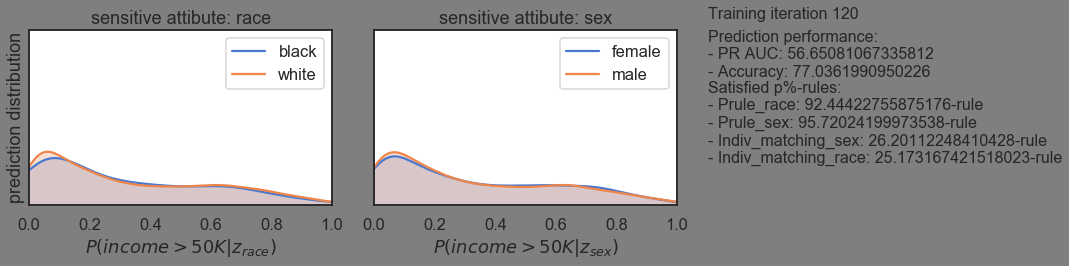

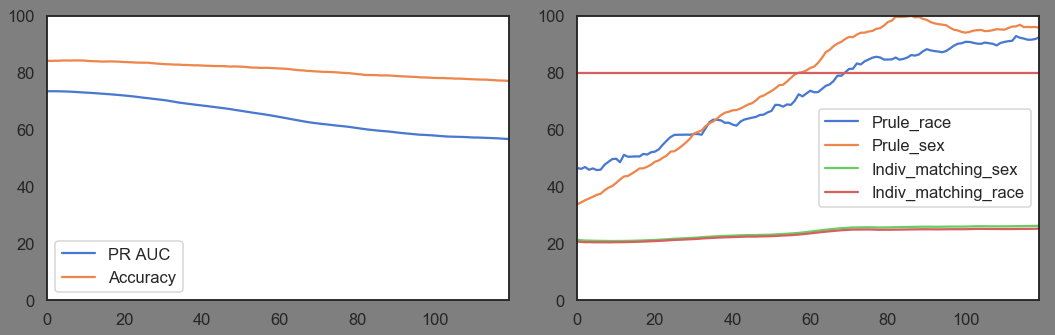

<Figure size 432x288 with 0 Axes>

In [19]:
# initialise FairClassifier
clf = MultiFairnessClassifier(n_unprotected=X_train.shape[1], n_protected=Z_train.shape[1],
                     lambdas=params["lambdas"], alphas=params["alphas"])#Here Race:130, sex: 30 --> Heuristically gotten via balanced increaser
#p-rule values during training. Interpretation: harder to balance race than sex
if params["nb_pretrain"] != 0:
    clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=params["nb_pretrain"])
if params["nb_light_pretrain"] != 0:
    clf.light_pretrain(X_train, y_train, Z_train, verbose=0, epochs=params["nb_light_pretrain"])

# adverserial train on train set and validate on test set
preds, perf_metrics, fairness_metrics = clf.fit(X_train, y_train, Z_train, 
        validation_data=(X_test, y_test, Z_test),
        matchings = (test_mate_race, test_mate_sex),
        T_iter=params["nb_epochs"], save_figs=False)

# Run repeated experiments

In [20]:
def run_repetitions(train_data, test_data, nb_repetitions, lambdas, alphas, nb_train, nb_pretrain=0, nb_light_pretrain=0):
    assert (nb_pretrain !=0) + (nb_light_pretrain !=0) <=1
    pretrain_str = 'pretrain_'+str(nb_pretrain) if nb_pretrain !=0 else ('lightpretrain_'+ str(nb_light_pretrain) if nb_light_pretrain != 0 else '')
    exp_title = pretrain_str + '_iter_'+str(nb_train)+ '_alphas_'+str(alphas[0])+'_'+str(alphas[1])
    
    repetitions = pd.DataFrame()    
    X_train, y_train, Z_train = train_data
    X_test, y_test, Z_test = test_data
    
    for i in range(0,nb_repetitions):
        print("Current repetition ", i)
        clf = MultiFairnessClassifier(n_unprotected=X_train.shape[1], n_protected=Z_train.shape[1], lambdas=lambdas, alphas=alphas)
        if nb_pretrain != 0:
            clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=nb_pretrain)
        elif nb_light_pretrain != 0:
            clf.light_pretrain(X_train, y_train, Z_train, verbose=0, epochs=nb_light_pretrain)
        
        preds_arr, val_metric, fairness_metric = clf.fit(X_train, y_train, Z_train, validation_data=(X_test,y_test, Z_test), matchings = (test_mate_race, test_mate_sex), T_iter=nb_train, save_figs=False)

        repetitions['PR_AUC_'+str(i)] = val_metric['PR AUC']
        repetitions['prule_race_'+str(i)] = fairness_metric['Prule_race']
        repetitions['prule_sex_'+str(i)] = fairness_metric['Prule_sex']
        repetitions['indiv_race_'+str(i)] = fairness_metric['Indiv_matching_race']
        repetitions['indiv_sex_'+str(i)] = fairness_metric['Indiv_matching_sex']
    
    columns = repetitions.columns
    auc_cols = [c for c in columns if 'PR_AUC_' in c]
    p_race_cols = [c for c in columns if 'prule_race_' in c]
    p_sex_cols = [c for c in columns if 'prule_sex_' in c]
    i_race_cols = [c for c in columns if 'indiv_race_' in c]
    i_sex_cols = [c for c in columns if 'indiv_sex_' in c]

    repetitions['PR_AUC_avg'] = repetitions[auc_cols].mean(axis=1)
    repetitions['prule_race_avg'] = repetitions[p_race_cols].mean(axis=1)
    repetitions['prule_sex_avg'] = repetitions[p_sex_cols].mean(axis=1)
    repetitions['indiv_race_avg'] = repetitions[i_race_cols].mean(axis=1)
    repetitions['indiv_sex_avg'] = repetitions[i_sex_cols].mean(axis=1)
    
    fig, axes = plt.subplots(1,2, figsize=(15, 5))
    fig.patch.set_facecolor('tab:gray')
    ax = repetitions[[c for c in repetitions.columns if 'AUC_' in c and 'avg' not in c]].plot(ylim=(0,100), ax=axes[0], color=["#b1bdbe"]*len(auc_cols))
    ax = repetitions['PR_AUC_avg'].plot(ylim=(0,100), ax=axes[0], color=["#9b59b6"])
    axes[0].legend(['PR_AUC_avg'])

    ax = repetitions[[c for c in repetitions.columns if 'AUC_' not in c and 'avg' not in c]].plot(ylim=(0,100), ax=axes[1],color=["#aac1c1", "#76c097","#ffd0bd", "#eac4d5" ]*len(p_race_cols))
    ax = repetitions['prule_race_avg'].plot(ylim=(0,100), ax=axes[1],color=["#888888"])
    ax = repetitions['prule_sex_avg'].plot(ylim=(0,100), ax=axes[1],color=["#487959"])
    ax = repetitions['indiv_race_avg'].plot(ylim=(0,100), ax=axes[1],color=["#ec7c7c"])
    ax = repetitions['indiv_sex_avg'].plot(ylim=(0,100), ax=axes[1],color=["#af3b6e"])
    axes[1].legend(['prule_race_avg','prule_sex_avg', 'indiv_race_avg', 'indiv_sex_avg'])
    ! mkdir experiments/$exp_title
    fig.savefig('experiments/'+exp_title+'/figure.png')
    repetitions.to_csv('experiments/'+exp_title+'/repetitions.csv', sep=',', encoding='UTF-8', index=False)
    
    return repetitions[['PR_AUC_avg', 'prule_race_avg','prule_sex_avg', 'indiv_race_avg', 'indiv_sex_avg']]

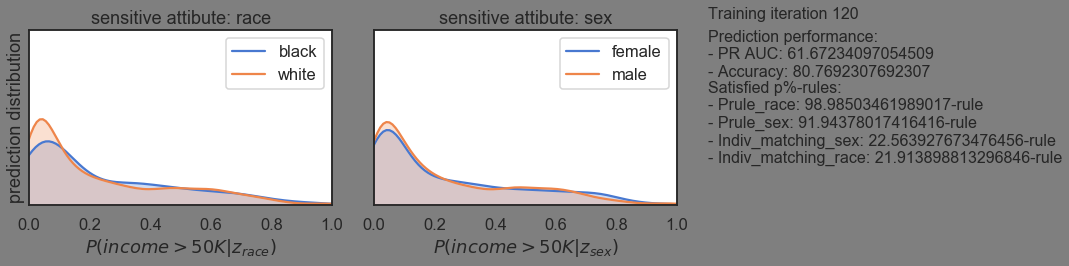

<Figure size 432x288 with 0 Axes>

mkdir: experiments/lightpretrain_1iter_120_alphas_1_0: File exists


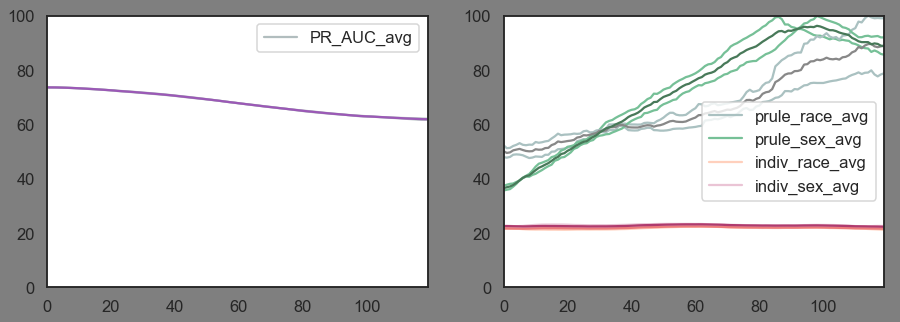

In [21]:
group_only = run_repetitions((X_train, y_train, Z_train), (X_test, y_test, Z_test), nb_repetitions=2, lambdas=[30., 50.], alphas=[1,0], nb_train=120, nb_light_pretrain=1)

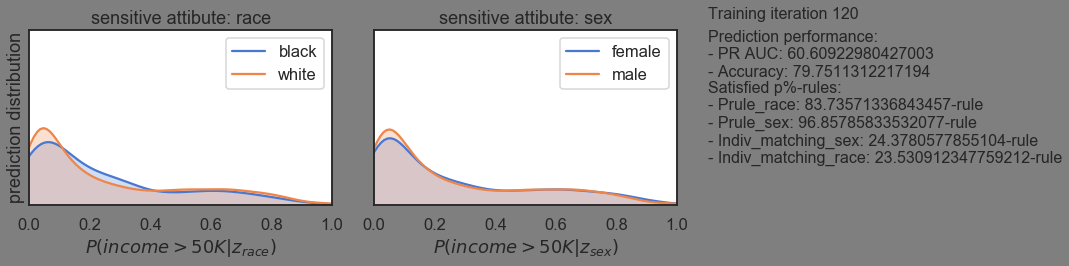

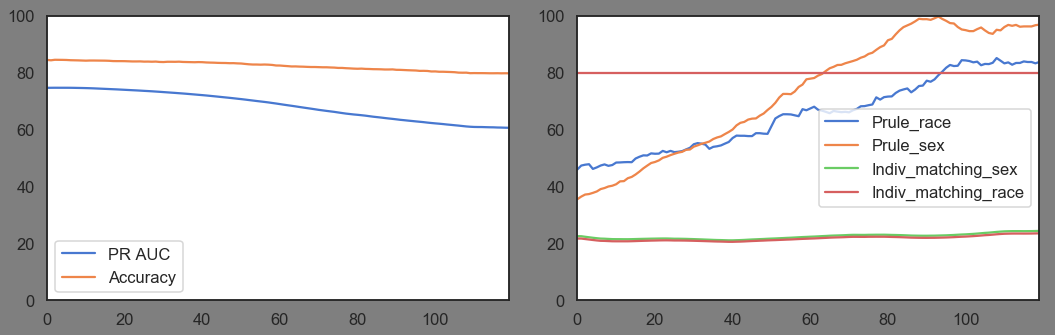

<Figure size 432x288 with 0 Axes>

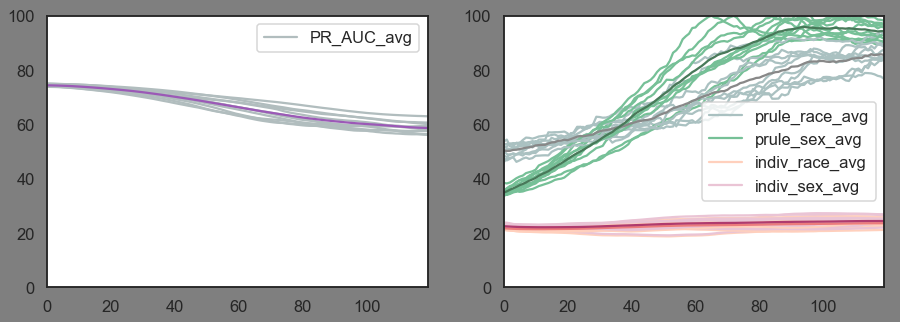

In [22]:
both = run_repetitions((X_train, y_train, Z_train), (X_test, y_test, Z_test), nb_repetitions=10, lambdas=[30., 50.], alphas=[1,2], nb_train=120, nb_light_pretrain=1)

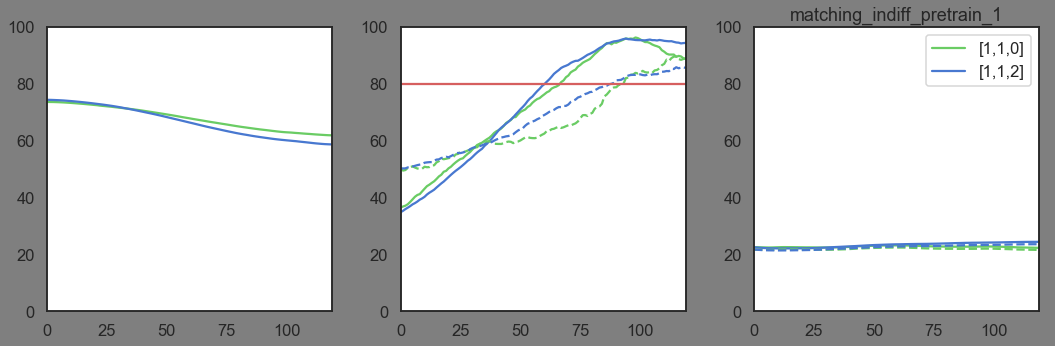

In [23]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
fig.patch.set_facecolor('tab:gray')
ax0 = group_only['PR_AUC_avg'].plot(ylim=(0,100), ax=axes[0], style='-g')
ax0 = both['PR_AUC_avg'].plot(ylim=(0,100), ax=axes[0], style='-b')
ax1 = group_only['prule_sex_avg'].plot(ylim=(0,100),ax=axes[1], style='-g')
ax1 = both['prule_sex_avg'].plot(ylim=(0,100),ax=axes[1], style='-b')
ax1 = group_only['prule_race_avg'].plot(ylim=(0,100),ax=axes[1], style='--g')
ax1 = both['prule_race_avg'].plot(ylim=(0,100), ax=axes[1],style='--b')
ax1.axhline(y=80, xmin=0, xmax=150, color='r')
ax2 = group_only['indiv_sex_avg'].plot(ylim=(0,100), style='-g')
ax2 = both['indiv_sex_avg'].plot(ylim=(0,100), style='-b')
ax2 = group_only['indiv_race_avg'].plot(ylim=(0,100), style='--g')
ax2 = both['indiv_race_avg'].plot(ylim=(0,100), style='--b')
fig.tight_layout()
fig.savefig('experiments/07_repetitions_lightpretrain_1_iter_150')
plt.legend(axes[0].lines, ('[1,1,0]', '[1,1,2]'))
plt.title("matching_indiff_pretrain_1")
plt.show()